# 前置階段

導入函示庫

In [1]:
import copy
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

資料集為`ap/mz`質譜圖  
先導入原始資料集並切割為一個`子長度為2`的`2-Dimensional`的`List`資料  

而其資料格式為：
```py
[["強度（amplitude）"], ["荷值比（m/z）"]]
```


In [2]:
piece = []

with open("./raw/List.txt", mode="r") as raw:
    for fragment in raw:
        piece.append(fragment.split())

print(f"陣列總長度：{len(piece)}")
print(f"取陣列第一筆資料檢查格式：{piece[0]}")

陣列總長度：107
取陣列第一筆資料檢查格式：['55.0', '5.809e4']


設計一個函式使`string（字串）`能夠依照科學記號轉換為`float（浮點數）`  
目的是讓不可被比較的`字串`資料類型轉換成可以比較的`浮點數`資料型態  

轉換方式抽象資料方法：$\text{Scientific Notation} = N_\text{float} \cdot E \pm K_\text{exponential}$

目前沒有遇過荷值比指數部分為負數，因此先不實作負指數轉換

In [3]:
# Abbriveation of "Scientific"
def snc(raw:str, restrict:bool=False, ndigits:int=1):

    raw = raw.split("e")
    final = float(raw[0])*(10**int(raw[1]))

    if restrict:
        return round(final, ndigits)
    else:
        return final

print(f"轉換前：{piece[0][1]}，資料型態為：{type(piece[0][1])}")
print(f"轉換前：{snc(piece[0][1])}，資料型態為：{type(snc(piece[0][1]))}")

轉換前：5.809e4，資料型態為：<class 'str'>
轉換前：58090.0，資料型態為：<class 'float'>


# 資料處理抽象概念與實作

為了能夠做預測，所以先將資料區分為四個不同權重的區間  
隨便把一個確定的樣本作為我的標準  

以下圖為例：  

可以看到綠色的`A區間`，雖然有資料，但對於整個模型而言是次等重要的區間  
橘色的`B區間`，為整個bar chart的最高峰值區間，在這個區間內的資料決定了大部分的判決  
藍色的`C區間`，也屬於子判決區，但會比`A區間`來的更低優先度  
最後`D區間`，可以視為整個資料裡的雜訊，所以優先度最低  

總結的話，各區間的優先度為：**B>A>C>D**

因為只有四個區間，所以我的作法是依據區間內的`資料密度*權重`來作為各個區間的`區間權重值`

![intervals](./image/interval.png)

In [4]:
# 權重區間表
token = [0.5, 1, 0.25, 0.01]

# 區間儲存陣列
intervals = [[], [], [], []]

# 先分類每筆資料到各個區間
for data in piece:

    if float(data[0]) <= 130:
        intervals[0].append(snc(data[1]))
    
    if float(data[0]) > 130 and float(data[0]) <= 158:
        intervals[1].append(snc(data[1]))

    if float(data[0]) > 158 and float(data[0]) <= 194:
        intervals[2].append(snc(data[1]))

    if float(data[0]) > 194.0:
        intervals[3].append(snc(data[1]))

print(f"區間A的資料筆數：{len(intervals[0])}")
print(f"區間B的資料筆數：{len(intervals[1])}")
print(f"區間C的資料筆數：{len(intervals[2])}")
print(f"區間D的資料筆數：{len(intervals[3])}")

區間A的資料筆數：55
區間B的資料筆數：20
區間C的資料筆數：17
區間D的資料筆數：15


In [5]:
for counter, interval in enumerate(intervals):
    accumulator = 0
    for data in interval:
        accumulator += data
    intervals[counter] = round(accumulator/len(intervals[counter])*token[counter])

print(f"區間A的區間權重值：{intervals[0]}")
print(f"區間B的區間權重值：{intervals[1]}")
print(f"區間C的區間權重值：{intervals[2]}")
print(f"區間D的區間權重值：{intervals[3]}")

區間A的區間權重值：101861
區間B的區間權重值：732713
區間C的區間權重值：81527
區間D的區間權重值：159


處理好區間權重值之後，就可以把資料製作成DataFrame格式，以利接下來的預測處理  

由於步驟全部都規畫好了，所以可以開始把資料抓進來，使用以上的方式製作前處裡樣本

In [6]:
# 建立DataFrame

dic = {
    "A-interval": [intervals[0]],
    "B-interval": [intervals[1]],
    "C-interval": [intervals[2]],
    "D-interval": [intervals[3]]
}

df = pd.DataFrame(dic)

print(df)

   A-interval  B-interval  C-interval  D-interval
0      101861      732713       81527         159


# 挖掘和正式資料前處理

測試完各項功能之後就是把所有資料抓出來做模型訓練  

因此使用`os`來走訪各個路徑下的資料集並製作成區間權重陣列  
最後再把全部的資料打包成一個矩陣

In [7]:
# 首先使用os.walk的方式把所有資料集的路徑取出來

task = []

for root, dirs, files in os.walk("./data", topdown=False):
    for name in files:
        if name.count(".txt"):
            task.append(os.path.join(root, name).replace("\\", "/"))

In [8]:
# 正式定義函數方法

def fetch_dataset(directory:str):
    dataset = []
    with open(directory, mode="r") as raw:
        for fragment in raw:
            dataset.append(fragment.split())
    return dataset

def snc(raw:str, restrict:bool=False, ndigits:int=1):
    raw = raw.split("e")
    final = float(raw[0])*(10**int(raw[1]))
    if restrict:
        return round(final, ndigits)
    else:
        return final

def lazy_interval(dataset:list, token:list=[0.5, 1, 0.25, 0.01]):
    intervals = [[], [], [], []]
    for data in dataset:
        if float(data[0]) <= 130:
            intervals[0].append(snc(data[1]))
        if float(data[0]) > 130 and float(data[0]) <= 158:
            intervals[1].append(snc(data[1]))
        if float(data[0]) > 158 and float(data[0]) <= 194:
            intervals[2].append(snc(data[1]))
        if float(data[0]) > 194.0:
            intervals[3].append(snc(data[1]))
    for counter, interval in enumerate(intervals):
        accumulator = 0
        for data in interval:
            accumulator += data
        intervals[counter] = round(accumulator/len(intervals[counter])*token[counter])
    return intervals

In [9]:
# 把全部資料集的區間加權值都計算出來

global_intervals = []

for i in task:
    global_intervals.append(lazy_interval(fetch_dataset(i)))

print(f"總計全部資料筆數：{len(global_intervals)}")
print(f"資料總數是否正確：{len(global_intervals) == len(task)}")

總計全部資料筆數：22
資料總數是否正確：True


In [10]:
# 處理各筆資料

dataset_A = []
dataset_B = []
dataset_C = []
dataset_D = []
dataset_type = []

for interval in global_intervals:
    dataset_A.append(interval[0])
    dataset_B.append(interval[1])
    dataset_C.append(interval[2])
    dataset_D.append(interval[3])
    dataset_type.append(1)

copied = [dataset_A, dataset_B, dataset_C, dataset_D, dataset_type]

In [11]:
# 交換區間製作不同種類的資料

exchange = copy.deepcopy(copied)

exchange[0], exchange[1] = exchange[1], exchange[0]
exchange[2], exchange[3] = exchange[3], exchange[2]

for counter, i in enumerate(exchange[4]):
    exchange[4][counter] = 2

print(copied == copied)
print(exchange == copied)

True
False


In [12]:
# 製作成DataFrame

dataset_A.extend(exchange[0])
dataset_B.extend(exchange[1])
dataset_C.extend(exchange[2])
dataset_D.extend(exchange[3])
dataset_type.extend(exchange[4])

dataset = pd.DataFrame(
    list(zip(dataset_A, dataset_B, dataset_C, dataset_D, dataset_type)),
    columns=["A", "B", "C", "D", "target"]
)

print(dataset)

          A        B       C       D  target
0    214861  1403605   68327     246       1
1    192401  1012803   70794     211       1
2    164653   852439   70433     194       1
3    194933   917072   73045     202       1
4    185557   991800   54375     232       1
5    195966   860165   68813     275       1
6    168324  1014385   48103     258       1
7    101861   732713   81527     159       1
8    178878   985681   50203     266       1
9    165409   724844   58157     203       1
10   303129  1988739  142614     285       1
11   215597  1161455   54959     262       1
12   235334   993181   63804     319       1
13   127015   629272   45026     203       1
14   145055   645487   52593     183       1
15   142699   753021   62188     179       1
16   234486  1128694   75695     361       1
17   255452  1087454   49428     470       1
18   463704  2272382  113164     647       1
19   184489   921991   46180     207       1
20   211552   841981   75535     222       1
21   19834

# K-NN預測

In [13]:
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

x = pd.DataFrame(dataset, columns=["A", "B", "C", "D"])
y = pd.DataFrame(dataset["target"], columns=["target"])
df = pd.concat([x,y], axis=1)

df.head()

,A,B,C,D,target
0,214861,1403605,68327,246,1
1,192401,1012803,70794,211,1
2,164653,852439,70433,194,1
3,194933,917072,73045,202,1
4,185557,991800,54375,232,1


In [14]:
print(df.isnull().values.sum())
print("資料筆數:", df.shape)
print("資料的欄位名稱，分別是:", df.keys())
print("第一筆的資料內容:", df.iloc[0,::])
print("第一筆的預測目標:", df["target"][0])


0
資料筆數: (44, 5)
資料的欄位名稱，分別是: Index(['A', 'B', 'C', 'D', 'target'], dtype='object')
第一筆的資料內容: A          214861
B         1403605
C           68327
D             246
target          1
Name: 0, dtype: int64
第一筆的預測目標: 1


In [15]:
print(df.head())
print(df.groupby("target").size())

        A        B      C    D  target
0  214861  1403605  68327  246       1
1  192401  1012803  70794  211       1
2  164653   852439  70433  194       1
3  194933   917072  73045  202       1
4  185557   991800  54375  232       1
target
1    22
2    22
dtype: int64


<Figure size 432x288 with 0 Axes>

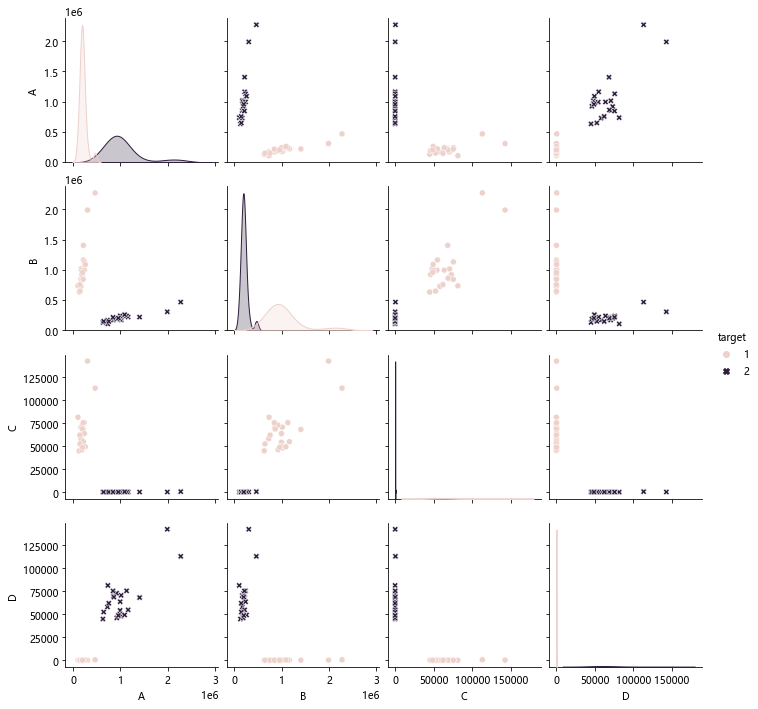

In [16]:
plt.figure()
sns.pairplot(df, hue = "target", markers=["o", "X"], vars=["A", "B", "C", "D"])
plt.show()

In [17]:
x = df[["A", "B", "C", "D"]]
y = df[["target"]]

train_X , test_X , train_y , test_y = train_test_split(x, y["target"],test_size=0.5,random_state=42)

print("訓練集的維度大小:   ", train_X.shape)
print("測試集的維度大小:   ", test_X.shape)

訓練集的維度大小:    (22, 4)
測試集的維度大小:    (22, 4)


In [18]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=3)

In [19]:
pred_y = model.predict(test_X)
print(accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

1.0
[[11  0]
 [ 0 11]]


# 邏輯回歸預測

In [20]:
x = pd.DataFrame(dataset, columns=["A", "B", "C", "D"])
y = pd.DataFrame(dataset["target"], columns=["target"])
df = pd.concat([x,y], axis=1)

In [21]:
print(dataset.isnull().values.sum())
print("資料筆數:", dataset.shape)
print("資料的欄位名稱，分別是:", dataset.keys())
print("第一筆的資料內容:", dataset.iloc[0,::])
print("第一筆的預測目標:",dataset["target"][0])

0
資料筆數: (44, 5)
資料的欄位名稱，分別是: Index(['A', 'B', 'C', 'D', 'target'], dtype='object')
第一筆的資料內容: A          214861
B         1403605
C           68327
D             246
target          1
Name: 0, dtype: int64
第一筆的預測目標: 1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


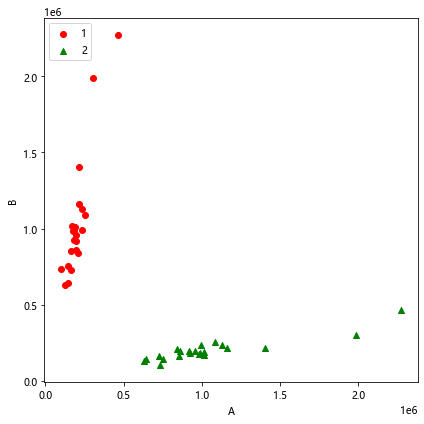

In [22]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"] 

markers = ("o", "^", "x")
colors = ("red", "green", "blue")
cmap = ListedColormap(colors[:len(np.unique(y))])

y = dataset["target"].values

for i, t in enumerate(np.unique(y)):  
    p = dataset[y == t]
    plt.scatter(x=p["A"],  y=p["B"], c=cmap(i), marker=markers[i],  label=t)

plt.xlabel("A")
plt.ylabel("B")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [23]:
dataset = dataset[["A","B","target"]]
dataset = dataset[dataset["target"].isin([1,2])] 
print(dataset["target"].value_counts())

1    22
2    22
Name: target, dtype: int64


In [24]:
train_X, test_X, train_y, test_y = train_test_split(dataset[["A","B"]], dataset[["target"]], test_size=0.5, random_state=42)

sc = StandardScaler()

train_X_std = sc.fit_transform(train_X)
test_X_std = sc.fit_transform(test_X)

print("訓練集的維度大小:   ", train_X_std.shape)
print("測試集的維度大小:   ", test_X_std.shape)

訓練集的維度大小:    (22, 2)
測試集的維度大小:    (22, 2)


In [25]:
model = LogisticRegression()
model.fit(train_X_std, train_y["target"])
print ("係數: ", model.coef_)
print ("截距: ", model.intercept_)

係數:  [[ 1.5834422  -1.36405206]]
截距:  [0.02104257]


In [26]:
print(model.predict(test_X_std))
print(test_y["target"].values)
print(model.predict_proba(test_X_std))

[2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 2]
[2 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 2]
[[0.11384645 0.88615355]
 [0.09215486 0.90784514]
 [0.08447066 0.91552934]
 [0.15404233 0.84595767]
 [0.07738196 0.92261804]
 [0.00332053 0.99667947]
 [0.9427695  0.0572305 ]
 [0.93396037 0.06603963]
 [0.94272093 0.05727907]
 [0.92434766 0.07565234]
 [0.94967457 0.05032543]
 [0.09981477 0.90018523]
 [0.13226477 0.86773523]
 [0.92782217 0.07217783]
 [0.94906963 0.05093037]
 [0.84309084 0.15690916]
 [0.08044782 0.91955218]
 [0.88869081 0.11130919]
 [0.87035392 0.12964608]
 [0.95850867 0.04149133]
 [0.06549489 0.93450511]
 [0.06578245 0.93421755]]


In [27]:
cm = confusion_matrix(test_y["target"], model.predict(test_X_std))
print(cm)

[[11  0]
 [ 0 11]]


In [28]:
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

x = test_X_std
y = test_y["target"].values

markers = ("o", "^", "x")
colors = ("red", "green", "blue")
cmap = ListedColormap(colors[:len(np.unique(y))])

x0min, x0max = x[:, 0].min() - 1, x[:, 0].max() + 1
x1min, x1max = x[:, 1].min() - 1, x[:, 1].max() + 1

a, b = np.meshgrid(np.arange(x0min, x0max, 0.03), np.arange(x1min, x1max, 0.03)) 

Z = model.predict(np.array([a.ravel(), b.ravel()]).T) 
Z = Z.reshape(a.shape)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


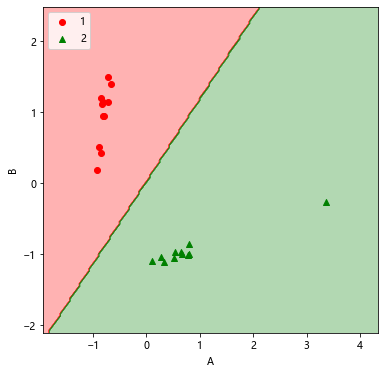

In [29]:
plt.rcParams["figure.figsize"] = (6, 6)

plt.contourf(a, b, Z, alpha=0.3, cmap=cmap)
plt.xlim(a.min(), a.max())
plt.ylim(b.min(), b.max())

for i, t in enumerate(np.unique(y)):  
    p = x[y == t]
    plt.scatter(x=p[:,0],  y=p[:,1], c=cmap(i), marker=markers[i],  label=t)

plt.xlabel("A")
plt.ylabel("B")
plt.legend(loc="upper left")
plt.show()